In [1]:
import graspy

import matplotlib.pyplot as plt
import numpy as np

from graspy.plot import heatmap
from graspy.simulations import sbm
from scipy.stats import chisquare
from scipy.stats import fisher_exact
from scipy.stats import ttest_ind

from mgcpy.independence_tests.dcorr import DCorr
from mgcpy.hypothesis_tests.transforms import k_sample_transform
from mgcpy.independence_tests.mgc import MGC



def _n_to_labels(n):
        n = np.array(n)
        n_cumsum = n.cumsum()
        labels = np.zeros(n.sum(), dtype=np.int64)
        for i in range(1, len(n)):
                labels[n_cumsum[i - 1] : n_cumsum[i]] = i
        return labels




Making population 1...


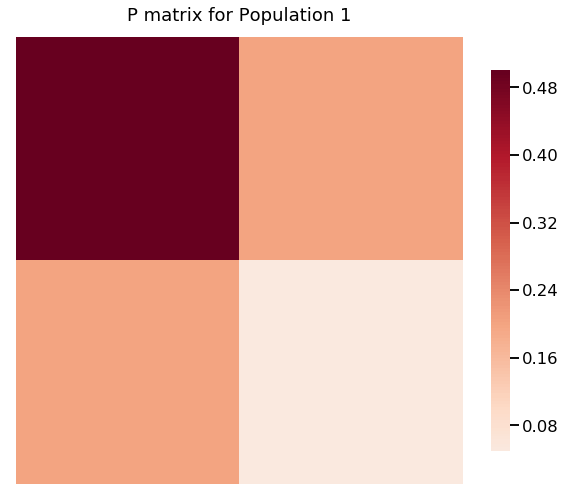

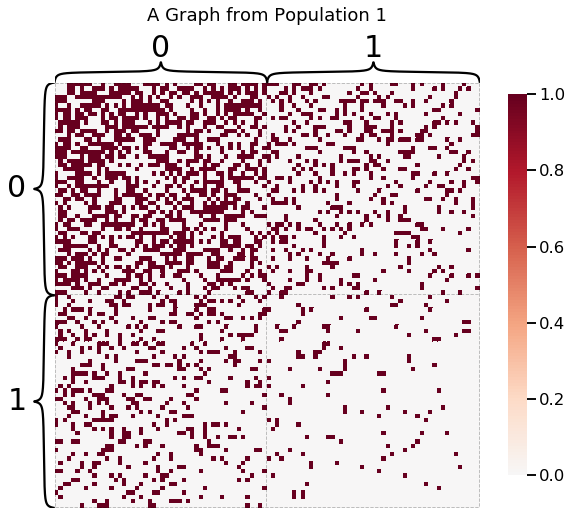

In [2]:
#Create population 1
print('Making population 1...')
m=100
n1 = [50, 50]
p1 = [[0.5, 0.2],
     [0.2, 0.05]]

np.random.seed(0)
for g in range(m):
	if g==0:
		P1 = sbm(n=n1, p=p1)
		P1 = np.expand_dims(P1,2)
	else:
		P1 = np.append(P1,np.expand_dims(sbm(n=n1, p=p1),2),axis=2)

lbls1 = _n_to_labels(np.array(n1))
plot = heatmap(np.array(p1),title='P matrix for Population 1')
plot = heatmap(P1[:,:,0],inner_hier_labels=lbls1, title ='A Graph from Population 1')

Making population 2...
Sigma is 0.03


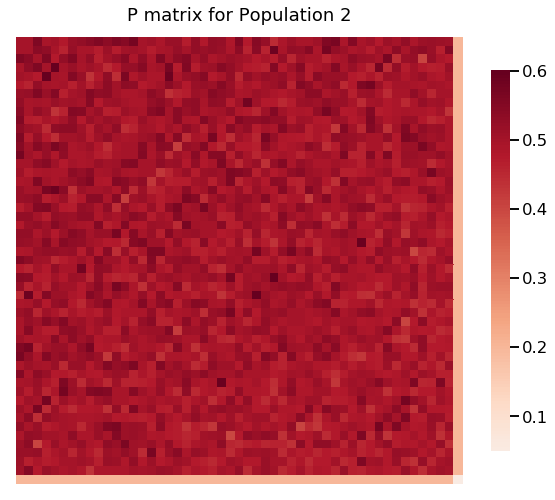

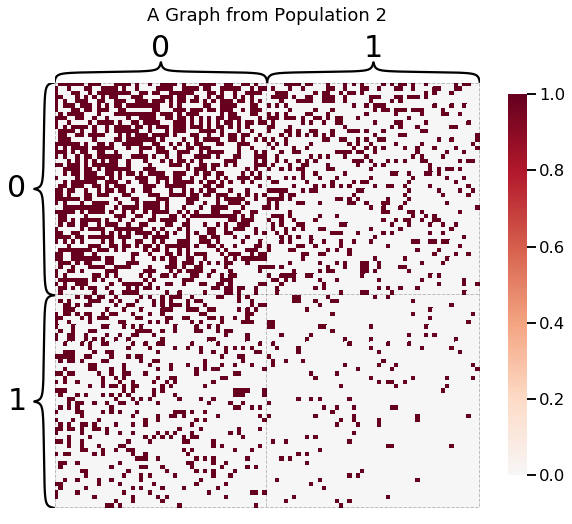

In [3]:
#Create population 2
print('Making population 2...')
sig=0.03
print('Sigma is ' + str(sig))

p_delta = np.random.normal(loc=0,scale=sig,size = (n1[0],n1[0]))
p_delta[p_delta<-0.5] = -0.5
p_delta[p_delta>0.5] = 0.5
np.fill_diagonal(p_delta,0)
for i in range(n1[0]):
    for j in range(i+1,n1[0]):
        p_delta[i,j] = p_delta[j,i]
p2 = np.zeros((n1[0]+1,n1[0]+1))
p2[:-1,:-1] = p_delta+0.5
p2[:,-1] = 0.2
p2[-1,:] = 0.2
p2[-1,-1] = 0.05

n2 = n1[0]*[1]+[50]


for g in range(m):
	if g==0:
		P2 = sbm(n=n2, p=p2)
		P2 = np.expand_dims(P2,2)
	else:
		P2 = np.append(P2,np.expand_dims(sbm(n=n2, p=p2),2),axis=2)

lbls2 = _n_to_labels(n1)

plot = heatmap(np.array(p2),title='P matrix for Population 2')
plot = heatmap(P2[:,:,0],inner_hier_labels=lbls2, title ='A Graph from Population 2')

Performing edgewise test...
Number of significant edges from T test with a=0.05, Bonferroni Correction: 0


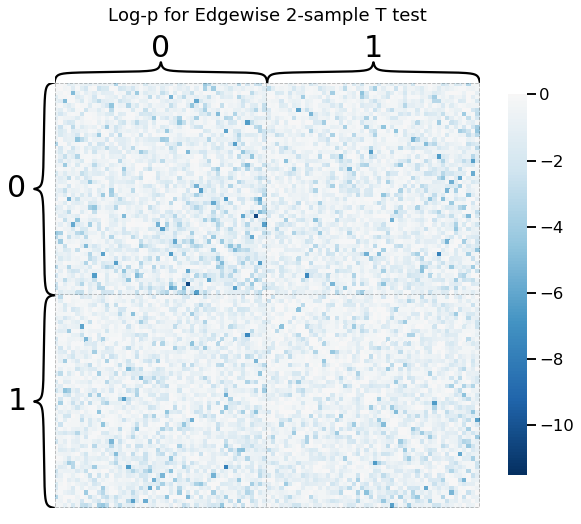

In [5]:
#Edgewise test
print('Performing edgewise test...')
ps = np.zeros(P1.shape[:2])
for i in range(P1.shape[0]):
    for j in range(i+1,P1.shape[1]):
        edges_1 = P1[i,j,:]
        edges_2 = P2[i,j,:]
        table = np.array([[np.sum(edges_1),np.sum(edges_1 == 0)],
            [np.sum(edges_2),np.sum(edges_2 == 0)]])
        _,p = fisher_exact(table)
        _,p = ttest_ind(edges_1,edges_2)
        ps[i,j] = p
        ps[j,i] = p

num_tests = P1.shape[0]*(P1.shape[0]-1)/2
alpha_corrected = 0.05/num_tests
edgewise_sig = np.sum(ps < alpha_corrected) - np.sum(n1) #all diagonals are 0
print("Number of significant edges from T test with a=0.05, Bonferroni Correction: " + str(edgewise_sig))

vmin = np.log(alpha_corrected)

plot = heatmap(ps,inner_hier_labels=lbls1,
    title ='Log-p for Edgewise 2-sample T test',
    transform='log',vmin=vmin,vmax=0)

Performing blockwise test...
Number of significant blocks from 2-sample T-test with a=0.05, Bonferroni Correction: 0


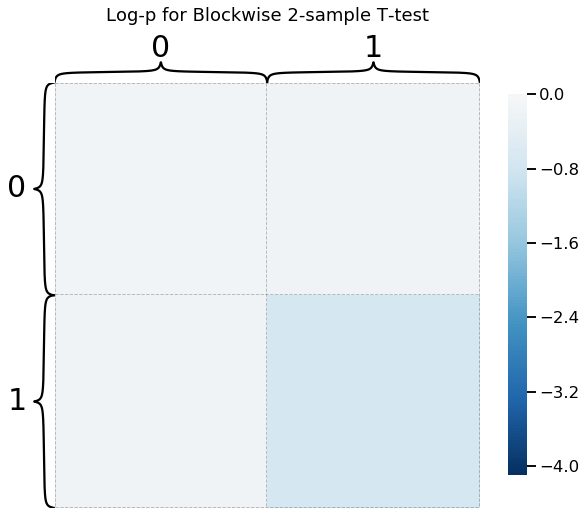

In [24]:
#Blockwise test
print('Performing blockwise test...')
indices_1 = np.cumsum(n1)
num_blocks = indices_1.shape[0]
p_blocks = np.zeros((num_blocks,num_blocks))
for i in np.arange(num_blocks):
    if i==0:
        start_i = 0
    else:
        start_i = indices_1[i-1]
    end_i = indices_1[i]
    for j in np.arange(i,num_blocks):
        if j==0:
            start_j = 0
        else:
            start_j = indices_1[j-1]
        end_j = indices_1[j]

        block_1 = np.sum(P1[start_i:end_i,start_j:end_j,:],axis=2)
        block_2 = np.sum(P2[start_i:end_i,start_j:end_j,:],axis=2)

        #don't be redundant - only use upper triangle if on a diagonal block
        if i == j:
            idxs = np.triu_indices(n1[i],1)
            binoms_1 = block_1[idxs]
            ones_1 = np.sum(binoms_1)
            zeros_1 = n1[i]*(n1[i]-1)*m/2 - ones_1
            
            binoms_2 = block_2[idxs]
            ones_2 = np.sum(binoms_2)
            zeros_2 = n1[i]*(n1[i]-1)*m/2 - ones_2
        else:
            binoms_1 = block_1.flatten()
            ones_1 = np.sum(binoms_1)
            zeros_1 = n1[i]**2*m - ones_1
            
            binoms_2 = block_2.flatten()
            ones_2 = np.sum(binoms_2)
            zeros_2 = n1[j]**2*m - ones_2
        table = np.array([[ones_1,zeros_1],
            [ones_2,zeros_2]])
        
        _,p = fisher_exact(table)
        _,p = ttest_ind(binoms_1,binoms_2)
        p_blocks[i,j] = p
        p_blocks[j,i] = p

num_tests = num_blocks*(num_blocks+1)/2
alpha_corrected = 0.05/num_tests
blockwise_sig = np.sum(p_blocks < alpha_corrected)
print("Number of significant blocks from 2-sample T-test with a=0.05, Bonferroni Correction: " + str(blockwise_sig))

vmin = np.log(alpha_corrected)

b00 = p_blocks[0,0]*np.ones((n1[0],n1[0]))
b01 = p_blocks[0,1]*np.ones((n1[0],n1[1]))
b10 = p_blocks[1,0]*np.ones((n1[1],n1[0]))
b11 = p_blocks[1,1]*np.ones((n1[1],n1[1]))
top = np.concatenate((b00,b01),axis=1)
bottom = np.concatenate((b10,b11),axis=1)
output = np.concatenate((top,bottom),axis=0)

plot = heatmap(output,inner_hier_labels=lbls1,
	title ='Log-p for Blockwise 2-sample T-test',
	transform='log',vmin=vmin,vmax=0)

Performing dcorr test...
Number of significant blocks from MGC with a=0.05, Bonferroni Correction: 1



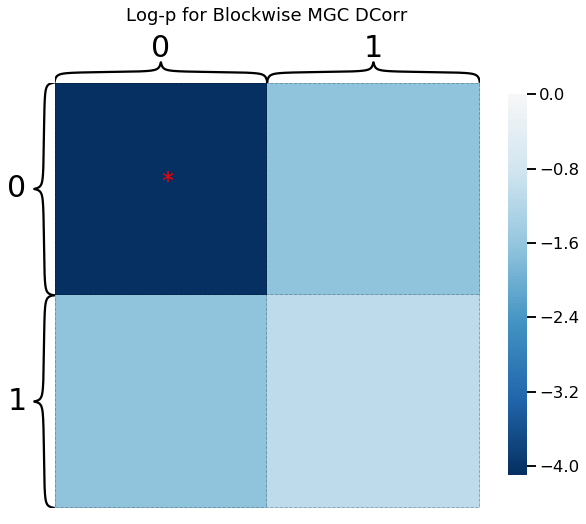

In [4]:
print('Performing dcorr test...')
dcorr = DCorr()

indices_1 = np.cumsum(n1)
num_blocks = indices_1.shape[0]
p_blocks = np.zeros((num_blocks,num_blocks))
lbls_block = np.arange(0,num_blocks)
replication_factor = 1000

for i in np.arange(num_blocks):
    if i==0:
        start_i = 0
    else:
        start_i = indices_1[i-1]
    end_i = indices_1[i]
    for j in np.arange(i,num_blocks):
        if j==0:
            start_j = 0
        else:
            start_j = indices_1[j-1]
        end_j = indices_1[j]
        
        block_1 = np.sum(P1[start_i:end_i,start_j:end_j,:],axis=2)
        block_2 = np.sum(P2[start_i:end_i,start_j:end_j,:],axis=2)

        #don't be redundant - only use upper triangle if on a diagonal block
        if i == j:
            idxs = np.triu_indices(n1[i],1)
            edges_1 = np.expand_dims(block_1[idxs].flatten(),1)
            edges_2 = np.expand_dims(block_2[idxs].flatten(),1)
        else:
            edges_1 = np.expand_dims(block_1.flatten(),1)
            edges_2 = np.expand_dims(block_2.flatten(),1)
            
        u,v = k_sample_transform(edges_1,edges_2)
        p,_ = dcorr.p_value(u,v, replication_factor=replication_factor)

        if p < 1/replication_factor:
            p = 1/replication_factor

        p_blocks[i,j] = p
        p_blocks[j,i] = p

num_tests = num_blocks*(num_blocks+1)/2
alpha_corrected = 0.05/num_tests
blockwise_sig = np.sum(p_blocks < alpha_corrected)
print("Number of significant blocks from MGC with a=0.05, Bonferroni Correction: " + str(blockwise_sig))

vmin = np.log(alpha_corrected)

b00 = p_blocks[0,0]*np.ones((n1[0],n1[0]))
b01 = p_blocks[0,1]*np.ones((n1[0],n1[1]))
b10 = p_blocks[1,0]*np.ones((n1[1],n1[0]))
b11 = p_blocks[1,1]*np.ones((n1[1],n1[1]))
top = np.concatenate((b00,b01),axis=1)
bottom = np.concatenate((b10,b11),axis=1)
output = np.concatenate((top,bottom),axis=0)

plot = heatmap(output,inner_hier_labels=lbls1,
    title ='Log-p for Blockwise MGC DCorr',
    transform='log',vmin=vmin,vmax=0)
print()
txt = plot.text(25,25,'*',fontsize=24, color='red') #hardcoded